### Exploratory Data Analysis

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing datasets

rate = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
movie_name = pd.read_csv("ml-100k/u.item", sep='\|', header=None)
movie_name = movie_name[[0,1]]
movie_name.rename({0:"item_id", 1:"movie_name"}, axis=1, inplace=True)

In [3]:
rate.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
rate.shape

(100000, 4)

In [5]:
print("There are {} unique user in this dataset.".format(rate["user_id"].nunique()))

There are 943 unique user in this dataset.


In [6]:
movie_name.head()

,item_id,movie_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
movie_name.shape

(1682, 2)

In [8]:
# I will create new dataset with merging movie_name and rate dataframes.

movie = rate.merge(movie_name, how="left")

In [9]:
movie.shape

(100000, 5)

In [10]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     100000 non-null  int64 
 1   item_id     100000 non-null  int64 
 2   rating      100000 non-null  int64 
 3   timestamp   100000 non-null  int64 
 4   movie_name  100000 non-null  object
dtypes: int64(4), object(1)
memory usage: 4.6+ MB


In [11]:
movie.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


"rating" column will be important for us to identify correlations between movies. Minimum rating is 1 and maximum is 5. 

In [12]:
movie_ratings = movie.groupby("movie_name")["rating"].mean() # Taking the mean of every movie by the rating from users
movie_rating_count = movie.groupby("movie_name")["rating"].count() # Taking the count of every movie by the 
                                                                   #       number of rating from users

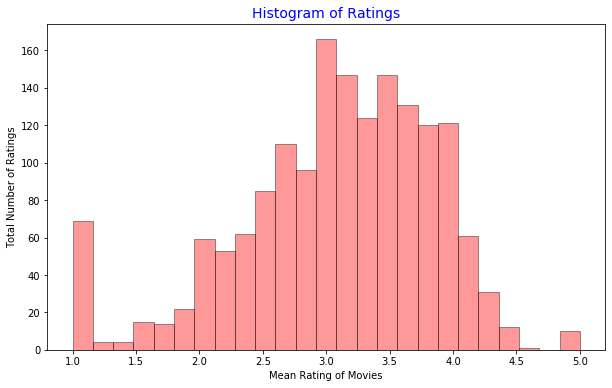

In [13]:
plt.figure(figsize=(10,6))
sns.distplot(movie_ratings, kde=False, hist_kws={"edgecolor":"black"}, color="red")
plt.xlabel("Mean Rating of Movies")
plt.ylabel("Total Number of Ratings")
plt.title("Histogram of Ratings", c="blue", size=14);

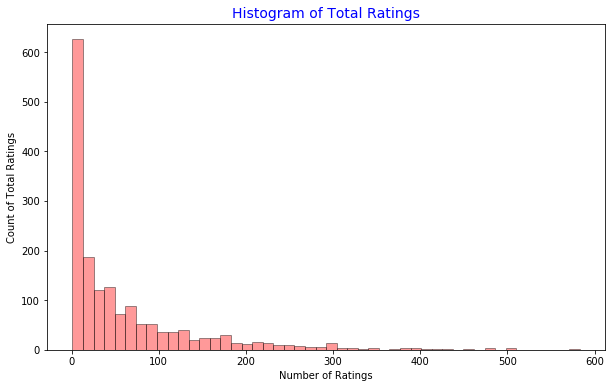

In [14]:
plt.figure(figsize=(10,6))
sns.distplot(movie_rating_count, kde=False, hist_kws={"edgecolor":"black"}, color="red")
plt.xlabel("Number of Ratings")
plt.ylabel("Count of Total Ratings")
plt.title("Histogram of Total Ratings", c="blue", size=14);

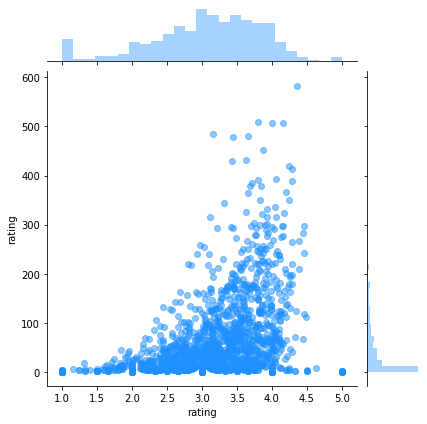

In [15]:
# Jointplot of movie ratings and rating count

sns.jointplot(movie_ratings, movie_rating_count, alpha=0.5, color="dodgerblue");

Ratings are mostly distributed between 2 and 4.5 . There are some movies that they have a few rate and they have high rating mean.

### Creating Recommender System

##### Corrwith Method

In [16]:
# Rating mean and rating count for each movie

df = movie_ratings.to_frame()
df["ratings_count"] = movie_rating_count
df.sort_values(by="ratings_count", ascending=False).head(10)

,rating,ratings_count
movie_name,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


In [17]:
# Rating of each user for each movie 

movie_matrix = movie.pivot_table(values="rating", index="user_id", columns="movie_name")
movie_matrix.head()

movie_name,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,� k�ldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


In [18]:
# Each user's rating for Star Wars and Air Force One movies.

starwars_movie_matrix = movie_matrix["Star Wars (1977)"]
airforce_movie_matrix = movie_matrix["Air Force One (1997)"]

In [19]:
# How correlated user's rating for other movies with Star Wars and Air Force One

similar_to_starwars = movie_matrix.corrwith(starwars_movie_matrix)
similar_to_airforce = movie_matrix.corrwith(airforce_movie_matrix)

In [20]:
similar_to_starwars.head()

movie_name
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

In [21]:
# Rating count of each movie and their correlation with Star Wars

corr_starwars = pd.DataFrame(similar_to_starwars, columns=["Correlation"])
corr_starwars.dropna(inplace=True)
corr_starwars = corr_starwars.join(df["ratings_count"])
corr_starwars.head()

,Correlation,ratings_count
movie_name,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [22]:
# Rating count of each movie and their correlation with Air Force One

corr_airforce = pd.DataFrame(similar_to_airforce, columns=["Correlation"])
corr_airforce.dropna(inplace=True)
corr_airforce = corr_airforce.join(df["ratings_count"])
corr_airforce.head()

,Correlation,ratings_count
movie_name,,
'Til There Was You (1997),0.867722,9
101 Dalmatians (1996),0.221943,109
12 Angry Men (1957),0.228031,125
187 (1997),0.294232,41
2 Days in the Valley (1996),0.043847,93


In [23]:
# Movies that are recommended by our system for Star Wars 

corr_starwars[corr_starwars["ratings_count"] > 100].sort_values(by="Correlation", ascending=False).iloc[1:4]

,Correlation,ratings_count
movie_name,,
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420


In [24]:
# Movies that are recommended by our system for Air Force One 

corr_airforce[corr_airforce["ratings_count"] > 100].sort_values(by="Correlation", ascending=False).iloc[1:4]

,Correlation,ratings_count
movie_name,,
"Hunt for Red October, The (1990)",0.554383,227
"Firm, The (1993)",0.526743,151
Murder at 1600 (1997),0.514906,218


---------

##### Nearest Neighbor

In [25]:
movie_matrix = movie.pivot_table(values="rating", index="movie_name", columns="user_id")
movie_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie_name,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),5.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187 (1997),NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
movie_matrix.fillna(0, inplace=True)
movie_matrix_csr = csr_matrix(movie_matrix.values)
model_knn = NearestNeighbors(n_neighbors=3, metric="cosine", algorithm="brute")
model_knn.fit(movie_matrix_csr)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=3)

In [27]:
index = 0
for i in movie_matrix.index:
    if "Air Force" in i:
        print("Index of Air Force One:",index)
    if "Star Wars" in i:
        print("Index of Star Wars:", index)
    index += 1

Index of Air Force One: 32
Index of Star Wars: 1398


In [28]:
distance_to_starwars, similar_starwars_indices = model_knn.kneighbors(movie_matrix.iloc[1398,:].values.reshape(1,-1), n_neighbors=4)
distance_to_airforceone, similar_airforceone_indices = model_knn.kneighbors(movie_matrix.iloc[32,:].values.reshape(1,-1), n_neighbors=4)

In [29]:
print("Recommended Movies for Star Wars by Using Nearest Neighbors")
print("***")
for i in similar_starwars_indices[0][1:]:
    print(movie_matrix.index[i])

Recommended Movies for Star Wars by Using Nearest Neighbors
***
Return of the Jedi (1983)
Raiders of the Lost Ark (1981)
Empire Strikes Back, The (1980)


In [30]:
print("Recommended Movies for Air Force One by Using Nearest Neighbors")
print("***")
for i in similar_airforceone_indices[0][1:]:
    print(movie_matrix.index[i])

Recommended Movies for Air Force One by Using Nearest Neighbors
***
Conspiracy Theory (1997)
Contact (1997)
Liar Liar (1997)


### Conclusion

We created a recommender system for movie datasets with using Collaborative Filtering. There are 1682 movie and 100000 rating from 943 users. Most of the movies rated by less than 200 users. There are some movies that rated by small amount of users. But at the same time, they have high ratings. 

There are two techniques for Collaborative Filtering in this notebook. Corrwith and Nearest Neighbor

First recommender system takes into account that every recommendation should have higher correlation with selected movies and should have more than 100 rating count.

- For Star Wars, first system's recommendation are; Empire Strikes Back,The (1980) - Return of the Jedi (1983) - Raiders of the Lost Ark (1981) The Empire Strikes Back and Return of the Jedi are the movies from Star Wars universe. Raiders of the Lost Ark is an Adventure/Action movie.

- For Air Force One, first system's recommendation are; Hunt for Red October, The (1990) - Firm, The (1993)	- Murder at 1600 (1997) All the movies that recommended for Air Force One are in the same genre; Thriller/Action.

Second recommender system turns movie matrix into csr_matrix. Then, with using cosine metric in the  Nearest Neighbor algorithm we get the nearest neighbors of each data point. 

- For Star Wars, second system's recommendation are; Return of the Jedi (1983) - Raiders of the Lost Ark (1981) - Empire Strikes Back,The (1980). The Empire Strikes Back and Return of the Jedi are the movies from Star Wars universe. Raiders of the Lost Ark is an Adventure/Action movie.

- For Air Force One, second system's recommendation are; Conspiracy Theory (1997) - Contact (1997)	- Liar Liar (1997). Conspiracy Theory is a Thriller/Action, Contact is a Sci-fi, Liar Liar is a Comedy/Fantasy movies.

Using corrwith and specifying a limit to review for recommendation is more effective in this dataset.